In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# importing data

In [14]:
#loading data
file_1="../Dataset/B0005_dis_dataset.csv"
file_2="../Dataset/B0006_dis_dataset.csv"
dataset_1=pd.read_csv(file_1)
dataset_2=pd.read_csv(file_2)

C_max=2.05

#renaming columns for simplicity
dataset_1.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_1["current_load"]= abs(dataset_1["current_load"])

#removing ideling / starting and ending current level data  
df_1=dataset_1[(dataset_1.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_1["time"]=df_1["time"]/3600

#calculate Soc for each cycle
cycle_count=df_1["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_1[df_1['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_1["Soc"] = [(q / C_max) for q in Soc_list]
df_1["Soh"]=df_1["capacity"]/C_max

# selecting parameters 
att_=["cycle","capacity","voltage","current","temperature","current_load","voltage_load","time","Soc"]
att=["cycle","current_load","voltage_load","Soc","time"]
X_axis="cycle"

#seperating dataset
X_train = df_1[att]
y_train = df_1[["Soh"]]



#renaming columns for simplicity
dataset_2.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_2["current_load"]= abs(dataset_2["current_load"])

#removing ideling / starting and ending current level data  
df_2=dataset_2[(dataset_2.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_2["time"]=df_2["time"]/3600

#calculate Soc for each cycle
cycle_count=df_2["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_2[df_2['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_2["Soc"] = [(q / C_max) for q in Soc_list]
df_2["Soh"]=df_2["capacity"]/C_max

X_test = df_2[att]
y_test = df_2[["Soh"]]

# Train Polynomial model

In [15]:

# Generate polynomial features
poly = PolynomialFeatures(degree=1)  # Choose the degree based on your problem
X_poly = poly.fit_transform(X_train)

# Fit the polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly, y_train)

LinearRegression()

# Training Lstm model

In [16]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(25, activation='tanh', recurrent_activation='sigmoid', return_sequences=True,input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

d:\Work\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train, epochs=200,batch_size=32, verbose=1,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0967 - val_loss: 8.5658e-05
Epoch 2/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.4022e-04 - val_loss: 1.8238e-04
Epoch 3/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.8667e-05 - val_loss: 6.8066e-04
Epoch 4/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.3581e-05 - val_loss: 6.3013e-04
Epoch 5/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.7167e-05 - val_loss: 4.0239e-04
Epoch 6/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4049e-05 - val_loss: 1.7519e-04
Epoch 7/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.2433e-06 - val_loss: 1.6221e-05
Epoch 8/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.6686e-06 - val_loss: 3.8853e-05
Epoch 9/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.0384e-06 - val_loss: 1.2304e-05
Epoch 10/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.5967e-06 - val_loss: 1.7935e-05
Epoch 11/200
1129/1129 ━━━━━━━━━

# making prediction

In [24]:
X_test_poly = poly.transform(X_test)
poly_predictions = poly_reg_model.predict(X_test_poly)

# LSTM Predictions
X_test_scaled = scaler.transform(X_test)
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
lstm_predictions = lstm_model.predict(X_test_lstm)

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [25]:
poly_predictions

array([[0.99674387],
       [0.99676783],
       [0.99677593],
       ...,
       [0.57950412],
       [0.57955365],
       [0.57961282]])

In [26]:
lstm_predictions

array([[1.0081258 ],
       [1.0083407 ],
       [1.0084802 ],
       ...,
       [0.65842813],
       [0.65907824],
       [0.65978825]], dtype=float32)

# stacking prediction

In [27]:
# Calculate performance weighted average

rmse_poly = np.sqrt(metrics.mean_squared_error(y_test, poly_predictions))
rmse_lstm = np.sqrt(metrics.mean_squared_error(y_test, lstm_predictions))

# Assign weights inversely proportional to MSE

weight_poly = 1 / rmse_poly
weight_lstm = 1 / rmse_lstm
total_weight = weight_poly + weight_lstm
weight_poly /= total_weight
weight_lstm /= total_weight

# Combine predictions
combined_predictions = (weight_poly * poly_predictions + weight_lstm * lstm_predictions)

In [28]:
rmse_poly

0.0016844864053546936

# graph

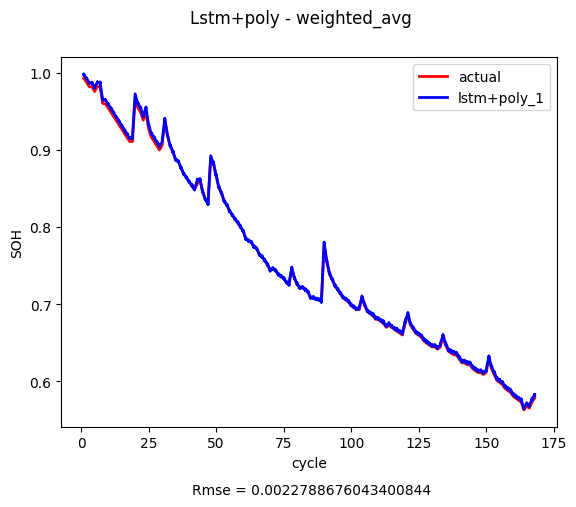

0.0022788676043400844


In [29]:
plt.plot(X_test["cycle"],y_test,color='red',label='actual',linewidth=2)
plt.plot(X_test["cycle"],combined_predictions,color='blue',label="lstm+poly_1",linewidth=2)
plt.xlabel("cycle")
plt.ylabel("SOH")
rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test,combined_predictions)))
plt.figtext(0.33, -0.03, rmse, fontsize=10)
plt.legend(loc="upper right")
plt.suptitle("Lstm+poly - weighted_avg")
plt.show()
print(np.sqrt(metrics.mean_squared_error(y_test,combined_predictions)))